<a href="https://colab.research.google.com/github/mohamed-mkh15/EDP/blob/main/Intro_to_3D_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook has mutiple perception excercises from reading RGBD images to object classification and identification**

### Playing with RGBD images

Libraries to install

In [ ]:
# pip install open3d
# pip install patool

First, I'll read and visualize an RGBDImage from the Redwood dataset [Choi2015]. link: http://redwood-data.org/3dscan/

In [ ]:
!git clone https://github.com/isl-org/redwood-3dscan.git
%cd redwood-3dscan
!python redwood_3dscan.py

In [23]:
import redwood_3dscan as rws

# Print RGBD scans (list)
print(rws.rgbds)

# Print meshes (list)
print(rws.meshes)

# Print categories (dict: string->list)
print(rws.categories)

# Print all scan_id of the "sofa" category
print(rws.categories["sofa"])

# Download by scan_id "00033"
# Download will be skipped if the resource is unavailable
# e.g. some RGBD images may not come with mesh.
# rws.download_rgbd("00033")  # Save to data/rgbd/00033.zip, if available
# rws.download_mesh("00033")  # Save to data/mesh/00033.ply, if available
# rws.download_video("00033") # Save to data/video/00033.mp4, if available
# rws.download_all("00033")   # Downloads rgbd, mesh, and video together

# Download by category "sofa"
# rws.download_category("sofa")

/content/redwood-3dscan
['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00075', '00076', '00077', '00078', '00079', '00080', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00094', '00095', '00096', '00097', '00098', '00099', '00100', '00101', '00102', '00103', '00104', '00105', '00106', '00107', '00108', '00

In [ ]:
import open3d as o3d

# rws.download_mesh("00033")
mesh = o3d.io.read_triangle_mesh("data/mesh/00577.ply")
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

Here I'll just extract an RGBD example to view it as it's automatically downloaded as zip file

In [ ]:
import patoolib

patoolib.extract_archive('/content/redwood-3dscan/data/rgbd/00033.zip')

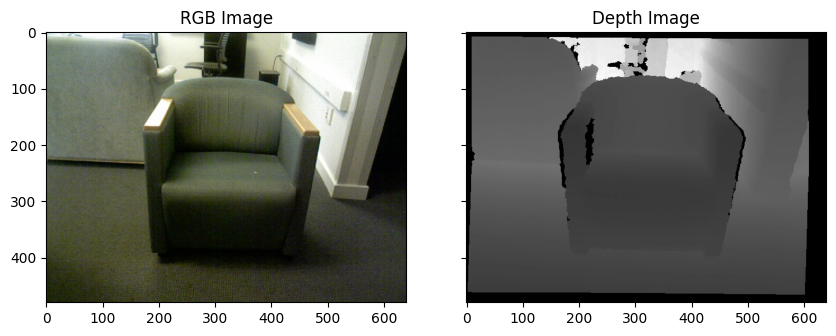

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

depth_image = mpimg.imread('/content/00033/depth/0000001-000000000000.png')
rgb_image = mpimg.imread('/content/00033/rgb/0000001-000000000000.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
f.tight_layout()
ax1.imshow(rgb_image)
ax1.set_title('RGB Image', fontsize=12)

ax2.imshow(depth_image, cmap='gray')
ax2.set_title('Depth Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now I'll just plot the RGBD as a point cloud

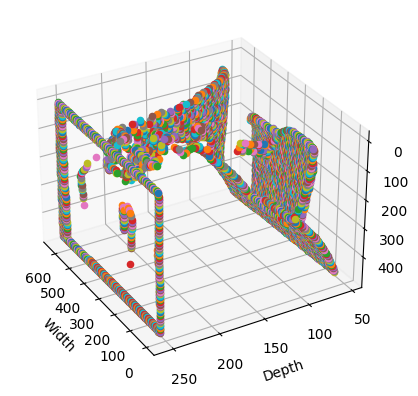

Outputted 12288 of the 307200 points
Results produced in 217.78 seconds


In [37]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from time import time

#############################
# Hit Test Run to Visualize #
#############################

start_time = time()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rows, cols = depth_image.shape

# Send pixels not correctly mapped to the back
max_val = depth_image.max()

count = 0

# Cut down pixels for time purpose
pixel_cut = 5

# Iterate thorugh all the pixels
for x in range(cols):
    for y in range(rows):
        if (x % pixel_cut == 0 and y % pixel_cut == 0):

            # Count points done
            count+=1

            # Get point color for pixel
            pixel_color = [rgb_image[y,x,0],rgb_image[y,x,1],rgb_image[y,x,2]]

            # Get point depth for each particle
            depth = depth_image[y,x]/max_val * 256

            # Send points not correctly mapped to the back
            if depth == 0:
                depth = 256 #max_val
            # print(x, depth, y, pixel_color)
            ax.scatter(x, depth, y, marker='o')

# Axis Labels
ax.set_xlabel('Width')
ax.set_ylabel('Depth')
ax.set_zlabel('Height')

plt.gca().invert_zaxis()

###########################################
# Play with me to change view rotation!
elevation = 30 # Up/Down
azimuth = 300 # Left/Right
###########################################


ax.view_init(elevation, azimuth)

plt.show() # Uncomment if running on your local machine
print ("Outputted {} of the {} points".format(count,rows*cols))
print ("Results produced in {:04.2f} seconds".format(time()-start_time))

### Camera calibration

In [49]:
%cd ..

/content


In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import glob

# get images
# !wget -q -O board1 "https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Perspective_chessboard.png/244px-Perspective_chessboard.png"
# !wget -q -O board2 "https://i.stack.imgur.com/Q2l11.jpg"
board1 = 'board1'
board2 = 'board2'

# prepare object points
nx = 6  #TODO: enter the number of inside corners in x
ny = 9  #TODO: enter the number of inside corners in y

# # Make a list of calibration images
# images = glob.glob('./Cal*.jpg')
# Select any index to grab an image from the list
# idx = -1'244px-Perspective_chessboard.png'
# Read in the image
# img = mpimg.imread(images[idx])
img  = cv2.imread(board2)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print("ret: ", ret)
# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


ret:  False


In [ ]:
plt.imshow(hsv)

In [46]:
img.shape

(174, 244)